# Purpose:

2015-03-24 (Tuesday)

Use newly discovered database excel files to reason about where to look for infected flies in our collection.

# Implementation:

## Imports:

In [3]:
# imports
import sys
import os
import re

import datetime as dt

import pandas as pd
import numpy as np


from shapely.geometry import Polygon, Point
from geopy.distance import distance
from geopy.point import Point as GpyPoint
import geopandas as gpd
import descartes as dct
from geopandas import GeoDataFrame
from descartes import PolygonPatch

pd.set_option('display.max_columns', 60)

import seaborn as sns

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


# set figure characteristics

# size
sns.set_context("talk")

# style
sns.set_style("whitegrid")

## File paths:

In [5]:
# define paths to files
source_dir = '/home/gus/Dropbox/uganda_data/tsetse_database/districts'

all_xls_files_in_UGANDA_DATA = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/all_xls_files_in_UGANDA_DATA.txt"

traps_gps_geojson = "/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/traps/uganda_villages_gps_beadell.geojson"
village_gps_geojson = "/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/villages/uganda_villages_gps_beadell.geojson"

#Uganda map shapes
uganda_map = "/home/gus/OLD_DROPBOX/GIS/uganda/humanitarianresponse.info/uganda_district2010/Uganda_districts2010.geojson"


In [6]:
uganda_gdf = GeoDataFrame.from_file(uganda_map)

In [7]:
type(uganda_gdf)

geopandas.geodataframe.GeoDataFrame

## Collect the files and create master dataframe

In [8]:
workbooks = []

In [9]:
for name in os.listdir(source_dir):
#     print os.path.splitext(name)
    if os.path.splitext(name)[-1].startswith('.xls'):
        workbooks.append(name)

In [10]:
workbooks[:5]

['Wakiso.xlsx',
 'Masindi.xlsx',
 'Kamwenge.xlsx',
 'Busia_yoosook.xls',
 'Apac.xlsx']

In [11]:
colsite_sheets = []

In [12]:
def load_xl_sheets(xl_path,sheet_startswith="COLSITE",keep_default_na=True):
    dfs = {}

    xls = pd.ExcelFile(xl_path)
    
    for sheet in xls.sheet_names:
        if sheet.upper().startswith(sheet_startswith):
            dfs[sheet] = pd.read_excel(io=xl_path,
                                       sheetname=sheet,
                                       na_values=[],
                                       keep_default_na=keep_default_na
                                      )

    return dfs

In [13]:
for wkbk in workbooks:
    dfs = load_xl_sheets(os.path.join(source_dir, wkbk),keep_default_na=False)
    
    for name, df in dfs.items():
        dfs[name]['source_file'] = wkbk
        colsite_sheets.append(dfs[name])
        
    
    

In [14]:
def save_geojson(gdf,path):
    with open(path, 'w') as geo_out:
        geo_out.write(gdf.to_json())

In [15]:
def extent_from_gdfs(gdf1,gdf2,margin=0,):
    """
    Returns intersection of gdf1 with rectangle infered from data in gdf2.
    """
    # define the coordinates at the extent of our point data for our map
    margin_width = margin
    lon_range = [gdf2['Longitude'].min() - margin_width, gdf2['Longitude'].max() + margin_width]
    lat_range = [gdf2['Latitude'].min() - margin_width, gdf2['Latitude'].max() + margin_width]

    # create a rectangle from these coordinates
    spatial_extent = Polygon([(lon_range[0], lat_range[0]),
        (lon_range[0], lat_range[1]),
        (lon_range[1], lat_range[1]),
        (lon_range[1], lat_range[0])])

    # get the shapes with geopandas intersects, which pulls the full shape
    return gdf1[gdf1['geometry'].intersects(spatial_extent)]

In [83]:
table = pd.concat(colsite_sheets)

In [84]:
table.head()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Wakiso.xlsx
1,AP?,Apac,,1.9756,32.5386,Uganda,Apac,,,,,,,,,Wakiso.xlsx
2,BB,Bulanga B,,1.068104,33.77734,Uganda,Budaka,20,,,,,,,,Wakiso.xlsx
3,BB20,Bulanga B Trap 20,,1.0728,33.77953,Uganda,Budaka,20,,,,,,,,Wakiso.xlsx
4,BB21,Bulanga B Trap 21,,1.0725,33.77938,Uganda,Budaka,21,,,,,,,,Wakiso.xlsx


In [99]:
floatable = table.latitude.apply(lambda x: x is not '')

In [100]:
floatable_indexes = list(table[floatable].index)

In [107]:
table_latlon = table.ix[floatable_indexes]

In [108]:
table_latlon.latitude.apply(lambda x: x is '').unique()

array([False], dtype=object)

In [112]:
table_latlon.latitude.apply(type).unique()

array([<type 'numpy.float64'>], dtype=object)

In [110]:
table_latlon.latitude.astype(np.float).apply(type).unique()

array([<type 'numpy.float64'>], dtype=object)

In [111]:
table_latlon.loc[:,'latitude'] = table_latlon.latitude.astype(np.float, copy=False)
table_latlon.loc[:,'longitude'] = table_latlon.longitude.astype(np.float, copy=False)

## Pull out data for uganda and make the maps

In [113]:
letter_code = re.compile(u'^\D+', re.UNICODE)

def deduce_village(df):

    recode_func = lambda x: letter_code.findall(x)[0]

    village = df.id.apply(recode_func)
    df.loc[:,"village_code"] = village

In [114]:
# pdb

In [115]:
table_latlon.tail()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kabarole.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kumi.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Arua.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Budaka.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Busia.xlsx


In [116]:
table_latlon = table_latlon.drop_duplicates()
deduce_village(table_latlon)

In [117]:
table_latlon.tail()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file,village_code
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kabarole.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kumi.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Arua.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Budaka.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Busia.xlsx,UGT


In [119]:
uganda = table_latlon.query('country == "Uganda"')

In [120]:
uganda.head()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file,village_code
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Wakiso.xlsx,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Masindi.xlsx,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Kamwenge.xlsx,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Busia_yoosook.xls,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Apac.xlsx,AP?


# Collect all trap GPS, save it

In [121]:
def lat_lon_to_geometry(df,lat='Latitude',lon='Longitude'):
    df["geometry"] = map(Point, df[lon], df[lat])

In [188]:
traps_gps = pd.DataFrame()
villages_gps = pd.DataFrame()

In [189]:
uganda['latitude'].apply(type).head()

0    <type 'numpy.float64'>
0    <type 'numpy.float64'>
0    <type 'numpy.float64'>
0    <type 'numpy.float64'>
0    <type 'numpy.float64'>
Name: latitude, dtype: object

In [190]:
traps_gps['Location'] = uganda['village_code']
traps_gps['Latitude'] = uganda['latitude']
traps_gps['Longitude'] = uganda['longitude']

lat_lon_to_geometry(traps_gps,lat='Latitude',lon='Longitude')
traps_gps = GeoDataFrame(traps_gps, geometry='geometry')

# traps_gps['Latitude'].apply(type).head()

In [194]:
print len(traps_gps)
print len(traps_gps.drop_duplicates())

7420
7411


In [184]:
# traps_gps = traps_gps.drop_duplicates()

In [195]:
# save geojson
# save_geojson(traps_gps,traps_gps_geojson)

In [65]:
print traps_gps_geojson

/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/traps/uganda_villages_gps_beadell.geojson


# Generate Village GPS and save it

In [197]:
village_gps = pd.pivot_table(traps_gps,index=['Location'],
                      values=['Longitude','Latitude'],
                      fill_value=0,
                      aggfunc=[np.median])
# print village_gps.head()
village_gps = village_gps['median']
village_gps = village_gps.reset_index()
# village_gps.head()

lat_lon_to_geometry(village_gps)
village_gps = GeoDataFrame(village_gps, geometry='geometry')
village_gps.head()

,Location,Latitude,Longitude,geometry
0,AP?,2.179190,32.791800,POINT (32.7918 2.17919)
1,BB,1.068104,33.778490,POINT (33.77849 1.068104)
2,BD,0.260897,33.929442,POINT (33.92944166666666 0.2608966666666667)
3,BG,1.619185,33.289898,POINT (33.28989846153846 1.619185)
4,BK,1.011333,33.861239,POINT (33.86123916666666 1.011333333333333)


In [198]:
# add geopy.Point column for distance calcs

get_geopy_point = lambda row: GpyPoint(latitude=row.Latitude, longitude=row.Longitude)

village_gps['geopy_point'] = village_gps.apply(get_geopy_point,axis=1)
village_gps.head()

,Location,Latitude,Longitude,geometry,geopy_point
0,AP?,2.179190,32.791800,POINT (32.7918 2.17919),"2° 10′ 45.084″ N, 32° 47′ 30.48″ E"
1,BB,1.068104,33.778490,POINT (33.77849 1.068104),"1° 4′ 5.1744″ N, 33° 46′ 42.564″ E"
2,BD,0.260897,33.929442,POINT (33.92944166666666 0.2608966666666667),"0° 15′ 39.228″ N, 33° 55′ 45.99″ E"
3,BG,1.619185,33.289898,POINT (33.28989846153846 1.619185),"1° 37′ 9.066″ N, 33° 17′ 23.6345″ E"
4,BK,1.011333,33.861239,POINT (33.86123916666666 1.011333333333333),"1° 0′ 40.8″ N, 33° 51′ 40.461″ E"


In [224]:
traps_gps['geopy_point'] = traps_gps.apply(get_geopy_point,axis=1)
traps_gps.head()

,Location,Latitude,Longitude,geometry,geopy_point
0,AP?,2.38278,33.045,POINT (33.045 2.38278),"2° 22′ 58.008″ N, 33° 2′ 42″ E"
0,AP?,2.38278,33.045,POINT (33.045 2.38278),"2° 22′ 58.008″ N, 33° 2′ 42″ E"
0,AP?,2.38278,33.045,POINT (33.045 2.38278),"2° 22′ 58.008″ N, 33° 2′ 42″ E"
0,AP?,2.38278,33.045,POINT (33.045 2.38278),"2° 22′ 58.008″ N, 33° 2′ 42″ E"
0,AP?,2.38278,33.045,POINT (33.045 2.38278),"2° 22′ 58.008″ N, 33° 2′ 42″ E"


In [199]:
len(village_gps)

36

In [201]:
# # save geojson
# save_geojson(village_gps,village_gps_geojson)
# print village_gps_geojson

# Pull out all sheets that start with "Tryp"

In [202]:
# get the list of excel files
paths = []

with open(all_xls_files_in_UGANDA_DATA,'rU') as all_xls:
    for line in all_xls:
        paths.append(line.rstrip('\n'))

In [203]:
# pdb

In [204]:
tryp_sheets = []
for wkbk in paths:
    dfs = load_xl_sheets(wkbk, sheet_startswith="TRYPAN")
    
    for name, df in dfs.items():
        dfs[name]['source_file'] = wkbk
        tryp_sheets.append(dfs[name])

df_tryps = pd.concat(tryp_sheets)

In [205]:
df_tryps.head()

,ITS1_assay,NRP_assay,SRA_Gibson,SRA_Radwanska,T. brucei,T. brucei COI sequence,T. brucei COI_Seq,Unnamed: 7,banked_sample_ID_fly,banked_sample_ID_trypanosome,banked_sample_id,banked_sample_id_trypanosome,curation_date,curator,internal_notes,public_notes,source_file,status,submission_date,submitter,trypanosome presence


In [206]:
len(tryp_sheets)

48

##  Load data from the prevalence paper from Chaz

In [207]:
wolbachia_data_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/prevalence_paper_files/2015-03-25_chaz_data/wolbachia_data.xlsx"

wolbachia_data_orig = pd.read_excel(io=wolbachia_data_path,
                                       sheetname=0,
                                       na_values=[],
                                       keep_default_na=False
                                      )
wolbachia_data_orig.head()

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
0,AP113,AP,,R,,Y,,,,N
1,AP114,AP,,R,,Y,,,,N
2,AP115,AP,,R,,Y,,,,N
3,AP116,AP,,R,,Y,,,,N
4,AP117,AP,,R,,Y,,,,N


In [208]:
wgro_sghv_ttub_infection_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/prevalence_paper_files/2015-03-25_chaz_data/wgro_sghv_ttub_infection.tsv"

wgro_sghv_ttub_infection = pd.read_csv(filepath_or_buffer=wgro_sghv_ttub_infection_path, sep='\t', na_filter=False)
wgro_sghv_ttub_infection.head()

,﻿ID,mtDNA,msat,GeoGen,Pop,Sex,Wgro,SGHV,Ttub
0,BK09001,N,N,NE,BK,F,1,0,0
1,BK09003,N,N,NE,BK,F,0,0,0
2,BK09006,N,N,NE,BK,M,1,0,0
3,BK09007,N,N,NE,BK,M,1,0,0
4,BK09009,N,N,NE,BK,M,1,0,0


In [209]:
wgro_sghv_ttub_infection.Pop.unique()

array(['BK', 'BN', 'PT', 'OS', 'DK', 'AR', 'MY', 'KL', 'NA', 'BU', 'BV',
       'JN', 'SS', 'MS', 'KR', 'KF', 'KB', 'KK'], dtype=object)

### Positives listed as from 'NA' population in `wgro_sghv_ttub_infection.tsv`

In [142]:
wgro_sghv_ttub_infection.query("Pop == 'NA'")

,﻿ID,mtDNA,msat,GeoGen,Pop,Sex,Wgro,SGHV,Ttub
206,KT08_01,S,S,SC,NA,F,0,0,0
207,KT08_02,S,S,SC,NA,F,0,0,0
208,KT08_03,S,S,SC,NA,na,0,0,0
209,NA08_01,S,S,SC,NA,M,1,0,0
210,NA08_02,S,S,SC,NA,M,0,0,0
211,NA08_03,S,S,SC,NA,F,0,0,0
212,NA08_04,S,S,SC,NA,F,0,0,0
213,NA08_05,S,S,SC,NA,F,0,0,0
214,NA08_06,S,S,SC,NA,F,0,0,0
215,NA08_07,S,S,SC,NA,M,0,1,1


In [210]:
wolbachia_data_orig.query("Population == 'NA'")

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
709,KT08_01,NA,F,W,2009,N,Y,N,N,S
710,KT08_02,NA,F,W,2009,N,N,N,N,S
711,KT08_03,NA,,W,2009,N,N,N,N,S
712,NA08_01,NA,M,W,2008,Y,N,,,S
713,NA08_02,NA,M,W,2008,N,N,N,N,S
714,NA08_03,NA,F,W,2008,N,N,N,N,S
715,NA08_04,NA,F,W,2008,N,Y,N,N,S
716,NA08_05,NA,F,W,2008,N,N,N,N,S
717,NA08_06,NA,F,W,2008,N,N,N,N,S
718,NA08_07,NA,M,W,2008,N,N,Y,Y,S


In [216]:
uganda.query("district == 'Wakiso'")

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file,village_code
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Wakiso.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Masindi.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Kamwenge.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Busia_yoosook.xls,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Apac.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Pallisa.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Mukono.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Busia.xls,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Dokolo#Uf022Kaberamaido.xlsx,KT
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,,,,,,,,,Butaleja.xlsx,KT


# Reload files but use 'SAMPLE' not 'COLSITE' as the sheet

In [143]:
# pdb

In [220]:
samples = []
for wkbk in paths:
    if "uganda_data" in wkbk:
        try:
            dfs = load_xl_sheets(wkbk, sheet_startswith="SAMPLE", keep_default_na=False)

            for name, df in dfs.items():
                dfs[name]['source_file'] = wkbk
                samples.append(dfs[name])
        except IndexError as exc:
            if "list index out of range" in exc.message:
                pass

df_samples = pd.concat(samples)

In [221]:
df_samples = df_samples.drop_duplicates()

In [222]:
mask2008 = df_samples.collection_id.apply(lambda x: x.endswith('2008'))
mask2009 = df_samples.collection_id.apply(lambda x: x.endswith('2009'))

In [223]:
df_samples[mask2009].query("population == 'OT'")

,aliguot_n,aliquot_n,banked_sample_id,collection_date,collection_id,collection_id.1,curation_date,curator,food_state,id,internal_notes,internal_notes.1,life_stage,population,public_notes,sex,size,source_file,species_id,species_id.1,species_identification,species_identification_method_id,specimen_id,stoage,storage,submission_date,submitter,tissue,tube_num
0,NaN,,OT09001,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
1,NaN,,OT09002,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
2,NaN,,OT09003,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
3,NaN,,OT09004,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
4,NaN,,OT09005,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
5,NaN,,OT09006,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
6,NaN,,OT09007,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,F,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
7,NaN,,OT09008,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
8,NaN,,OT09009,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,F,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
9,NaN,,OT09010,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,F,1,/home/gus/Dropbox/uganda_data/tsetse_database/...,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,


In [218]:
def plot_labels(gdf,label_column,offx=0.006,offy=0.004):
    
    pltme = lambda row: plt.text(x=row.Longitude+offx,
                                 y=row.Latitude+offy,
                                 s=row[label_column])
    
    gdf.apply(pltme,axis=1)
    
    

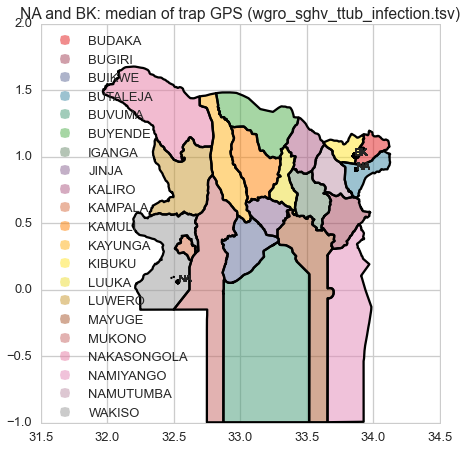

In [228]:
na = traps_gps.query("Location == 'NA'")
bk = traps_gps.query("Location == 'BK'")

na_bk = na.append(bk)

ext = extent_from_gdfs(uganda_gdf, na_bk)


na_bk.geometry = na_bk.buffer(0.008)


ext.plot(column='DNAME_2010', legend=True)
na_bk.plot()

plot_labels(na_bk,label_column='Location')

d = distance(na.geopy_point.iloc[0], bk.geopy_point.iloc[0]).kilometers
plt.title("NA and BK: median of trap GPS (wgro_sghv_ttub_infection.tsv)");



In [150]:
type(distance(na.geopy_point.iloc[0],bk.geopy_point.iloc[0]).kilometers)

float

In [151]:
wolbachia_data_orig.query("Population == 'NA'")

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
709,KT08_01,NA,F,W,2009,N,Y,N,N,S
710,KT08_02,NA,F,W,2009,N,N,N,N,S
711,KT08_03,NA,,W,2009,N,N,N,N,S
712,NA08_01,NA,M,W,2008,Y,N,,,S
713,NA08_02,NA,M,W,2008,N,N,N,N,S
714,NA08_03,NA,F,W,2008,N,N,N,N,S
715,NA08_04,NA,F,W,2008,N,Y,N,N,S
716,NA08_05,NA,F,W,2008,N,N,N,N,S
717,NA08_06,NA,F,W,2008,N,N,N,N,S
718,NA08_07,NA,M,W,2008,N,N,Y,Y,S


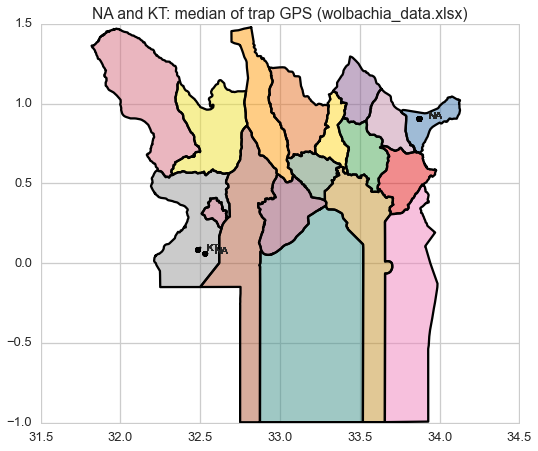

In [232]:
na = traps_gps.query("Location == 'NA'")
kt = traps_gps.query("Location == 'KT'")

na_kt = na.append(kt)

ext = extent_from_gdfs(uganda_gdf, na_kt)


na_kt.geometry = na_kt.buffer(0.01)


ext.plot(column='DNAME_2010', legend=False)
na_kt.plot()

plot_labels(na_kt,
            label_column='Location',
            offx=0.06,
            offy=0
           )

plt.title("NA and KT: median of trap GPS (wolbachia_data.xlsx)");

,Location,Latitude,Longitude,geometry,geopy_point


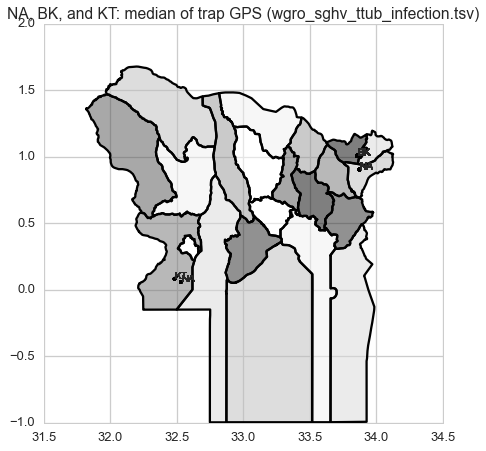

In [242]:
na = traps_gps.query("Location == 'NA'")
bk = traps_gps.query("Location == 'BK'")
kt = traps_gps.query("Location == 'KT'")

m1 = pd.merge(na,kt,how='outer')
na_bk_kt = pd.merge(m1,bk,how='outer')

ext = extent_from_gdfs(uganda_gdf, na_bk_kt)


na_bk_kt.geometry = na_bk_kt.buffer(0.005)


ext.plot()#column='DNAME_2010', legend=True)
na_bk_kt.plot()

plot_labels(na_bk_kt,label_column='Location')

plt.title("NA, BK, and KT: median of trap GPS (wgro_sghv_ttub_infection.tsv)");

### Specimens listed as from 'SS' population in `wolbachia_data.xlsx`

In [153]:
wolbachia_data_orig.query("Population == 'KJHD'").ID.apply(lambda x: x[:2]).unique()

array([], dtype=object)

In [154]:
uganda.query("village_code == 'BK'")

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file,village_code
31,BK,Nabiswa,,1.00655,33.85765,Uganda,Pallisa,,,,,,,,,Wakiso.xlsx,BK
32,BK,Nabiswa,,1.01269,33.8613,Uganda,Pallisa,1,,,,,,,,Wakiso.xlsx,BK
33,BK,Kadama,,1.010407,33.86122,Uganda,Pallisa,2,,,,,,,,Wakiso.xlsx,BK
34,BK01,Nabiswa location 1,,1.00655,33.85765,Uganda,Pallisa,1,,,,,,,,Wakiso.xlsx,BK
35,BK01,Nabiswa Trap 1,,1.01269,33.8613,Uganda,Pallisa,1,,,,,,,,Wakiso.xlsx,BK
36,BK01,Kadama Trap 1,,1.01248,33.86129,Uganda,Pallisa,1,,,,,,,,Wakiso.xlsx,BK
37,BK02,Nabiswa location 2,,1.00681,33.85737,Uganda,Pallisa,2,,,,,,,,Wakiso.xlsx,BK
38,BK02,Nabiswa Trap 2,,1.01226,33.86154,Uganda,Pallisa,2,,,,,,,,Wakiso.xlsx,BK
39,BK02,Kadama Trap 2,,1.01272,33.8615,Uganda,Pallisa,2,,,,,,,,Wakiso.xlsx,BK
40,BK03,Nabiswa Trap 3,,1.01231,33.86152,Uganda,Pallisa,3,,,,,,,,Wakiso.xlsx,BK


In [155]:
na

,Location,Latitude,Longitude,geometry,geopy_point
203,NA,0.481392,33.202972,POINT (33.20297166666667 0.4813916666666667),"0° 28′ 53.01″ N, 33° 12′ 10.698″ E"
